# Notebook focused on BLEURT 

In [1]:
import re
import pandas as pd
import copy
import numpy as np
import evaluate
from docx import Document
import os
import unittest
from datasets import load_dataset
import pickle
import matplotlib.pyplot as plt
from bleurt import score
class DataLoader:
    """
    Loader for benchmarking datasets to ensure universal formatting. To be used in conjunction with DyslexiaInjector.
    ...
    Attributes
    ----------
    path: str
        Path to csv, txt or docx file of the data. In the case of CSV there should only be 1 column
    data: list
        A list of striings
    dataset_name: str
        Name of the dataset that is used when saving the data
    ...
    Methods
    -------
    parse_txt(path)
        Parses a txt file and returns a list of strings
    fix_format(sentence)
        Fixes the formatting of a sentence
    save_as_txt(path)
        Saves the data as a txt file
    save_as_csv(path)
        Saves the data as a csv file
    save_as_docx(path)
        Saves the data as a docx file
    get_data()
        Returns the data
    create_deepcopy()
        Returns a deepcopy of the DataLoader instance
    get_name()
        Returns the dataset name
    get_number_of_sentences()
        Returns the number of sentences in the data
    get_number_of_words()
        Returns the number of words in the data
    get_number_of_letters()
        Returns the number of letters in the data
    edit_distance(reference_sentence, sentence)
        Returns the number of edits required to transform reference_sentence into sentence at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        also returns a dictionary of substitutions, insertions and deletions
    get_edit_distance(reference, manual_wer=False)
        Returns the number of edits required to transform data into reference at word level, substitutions, insertions and deletions the associated dictionaries
        and the WER (withouth alignment) if manual_wer is set to True
    get_individual_edit_distance(reference)
        Returns the number of edits required to transform data into reference at word level for each individual sentence
    combine_nested_dict(dict1, dict2)
        Combines two nested dictionaries
    combine_dicts(dict1, dict2)
        Combines two dictionaries
    get_bleue_score(reference)
        Returns bleu score of the data against a reference
    get_wer(reference)
        Returns the Word Error Rate (WER) of the data against a reference. With word alignment
    get_bert_score(reference)
        Returns the BLEURTScore similarity score of the data against a reference
    get_LaBSE(reference, model=None, tokenizer=None)
        Returns the LaBSE similarity score of the data against a reference which is a l2 norm between the reference and target sentences score.
        Score of 1 means the sentences are identical, closer to 0 means they are less similar semantically.
    ...

    Usage
    -------
    >>> from datasets import load_dataset
    >>> from DataLoader import DataLoader
    >>> dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
    >>> to_translate = []
    >>> for i in range(len(dataset_wmt_enfr)):
    >>>     to_translate.append(dataset_wmt_enfr[i]['translation']['en'])
    >>> loader = DataLoader(data=to_translate, dataset_name="wmt14_enfr")
    >>> loader.save_as_txt("wmt14_enfr.txt")
    We can also use the text file to create a new DataLoader instance
    >>> loader2 = DataLoader(path="wmt14_enfr.txt", dataset_name="wmt14_enfr")
    """
    # Constructor
    def __init__(self, path=None, data=None, dataset_name=""):
        self.dataset_name = dataset_name
        if data is None and path is not None:
            #check path to see if file is txt or csv
            file_type = path.split(".")[-1]
            if file_type == "txt":
                self.data = self.parse_txt(path)
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "csv":
                self.data = pd.read_csv(path, header=None)
                self.data = self.data[0].tolist()
                #fix any formatting issues
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "docx":
                doc = Document(path)
                self.data = [self.fix_format(paragraph.text) for paragraph in doc.paragraphs]
            else:
                raise Exception("Invalid file type")
        elif data is not None:
            #check if data is a list or a df
            if isinstance(data, list):
                #format each sentence in data
                self.data = [self.fix_format(sentence) for sentence in data]
            else:
                raise Exception("Invalid data type, please pass in a list of sentences")
        else:
            raise Exception("Please pass in a path or data")

    def parse_txt(self, path):
        output = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                output.append(self.fix_format(line))
        return output
                
    def fix_format(self, sentence):
        #remove spacing before punctuation
        sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', sentence)
        #replace any double spaces with single space
        sentence = re.sub(r'\s+', ' ', sentence)
        #remove any leading or trailing spaces
        sentence = sentence.strip()
        #make all quotes (german and french) english double quotes
        sentence = re.sub(r'«|»|„|“', '"', sentence)
        #make all single quotes english single quotes
        sentence = re.sub(r'‘|’', "'", sentence)
        #make all french guillemets english double quotes
        sentence = re.sub(r'‹|›', '"', sentence)
        #if sentence begins and ends with quotes and there are only two, remove them
        if sentence[0] == '"' and sentence[-1] == '"' and sentence.count('"') == 2:
            sentence = sentence[1:-1]
        elif sentence[0] == "'" and sentence[-1] == "'" and sentence.count("'") == 2:
            sentence = sentence[1:-1]
        return sentence

    def save_as_txt(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for sentence in self.data:
                f.write(f"{sentence}\n")
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_csv(self, path):
        df = pd.DataFrame(self.data)
        df.to_csv(path, index=False, header=False, encoding='utf-8')
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_docx(self, path):
        document = Document()
        for sentence in self.data:
            document.add_paragraph(sentence)
        document.save(path)
        print(f"Saved {self.dataset_name} to {path}")
        return

    def get_data(self):
        return self.data

    def create_deepcopy(self):
        return DataLoader(data=copy.deepcopy(self.data), dataset_name=self.dataset_name)
        
    def get_name(self):
        return self.dataset_name

    def get_number_of_sentences(self):
        return len(self.data)
    
    def get_number_of_words(self):
        return sum([len(sentence.split()) for sentence in self.data])
    
    def get_number_of_letters(self):
        #need to ensure we only count letters and not punctuation
        return sum([len(re.sub(r'[^\w\s]','',sentence)) for sentence in self.data])

    def edit_distance(reference_sentence, sentence):
        """
        Returns the number of edits required to transform reference_sentence into sentence at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        also returns a dictionary of substitutions, insertions and deletions
        """
        substitutions = 0
        insertions = 0
        deletions = 0
        substitution_dict = {}
        insertion_dict = {}
        deletion_dict = {}
        #remove punctuation and split into words
        sentence = re.sub(r'[^\w\s]','',sentence).lower().split()
        reference_sentence = re.sub(r'[^\w\s]','',reference_sentence).lower().split()
        #create matrix
        matrix = np.zeros((len(reference_sentence)+1,len(sentence)+1))
        #fill in first row and column
        for i in range(len(reference_sentence)+1):
            matrix[i][0] = i
        for j in range(len(sentence)+1):
            matrix[0][j] = j
        #fill in rest of matrix
        for i in range(1,len(reference_sentence)+1):
            for j in range(1,len(sentence)+1):
                if sentence[j-1] == reference_sentence[i-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(matrix[i-1][j-1], matrix[i-1][j], matrix[i][j-1])+1
        #backtrack to find edits
        i = len(reference_sentence)
        j = len(sentence)
        while i > 0 and j > 0:
            if sentence[j-1] == reference_sentence[i-1]:
                i -= 1
                j -= 1
            else:
                if matrix[i][j] == matrix[i-1][j-1]+1:
                    substitutions += 1
                    if reference_sentence[i-1] not in substitution_dict:
                        substitution_dict[reference_sentence[i-1]] = {sentence[j-1]:1}
                    else:
                        if sentence[j-1] not in substitution_dict[reference_sentence[i-1]]:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] = 1
                        else:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] += 1
                    i -= 1
                    j -= 1
                elif matrix[i][j] == matrix[i-1][j]+1:
                    deletions += 1
                    if reference_sentence[i-1] not in deletion_dict:
                        deletion_dict[reference_sentence[i-1]] = 1
                    else:
                        deletion_dict[reference_sentence[i-1]] += 1
                    i -= 1
                elif matrix[i][j] == matrix[i][j-1]+1:
                    insertions += 1
                    if sentence[j-1] not in insertion_dict:
                        insertion_dict[sentence[j-1]] = 1
                    else:
                        insertion_dict[sentence[j-1]] += 1
                    j -= 1
        while i > 0:
            deletions += 1
            if reference_sentence[i-1] not in deletion_dict:
                deletion_dict[reference_sentence[i-1]] = 1
            else:
                deletion_dict[reference_sentence[i-1]] += 1
            i -= 1
        while j > 0:
            insertions += 1
            if sentence[j-1] not in insertion_dict:
                insertion_dict[sentence[j-1]] = 1
            else:
                insertion_dict[sentence[j-1]] += 1
            j -= 1
        distance = substitutions+insertions+deletions
        return substitutions, insertions, deletions, substitution_dict, insertion_dict, deletion_dict, distance
        
    def get_edit_distance(self, reference, manual_wer=False):
        """
        Returns the number of edits required to transform data into reference at word level, substitutions, insertions and deletions the associated dictionaries
        and the WER (withouth alignment) if manual_wer is set to True
        """
        if type(reference) == list:
            substitutions = 0
            insertions = 0
            deletions = 0
            all_sub = {}
            all_ins = {}
            all_del = {}
            distance = 0
            for i in range(len(self.data)):
                sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, dist = DataLoader.edit_distance(reference[i], self.data[i], )
                all_sub = self.combine_nested_dict(all_sub, substitution_dict)
                all_ins = self.combine_dicts(all_ins, insertion_dict)
                all_del = self.combine_dicts(all_del, deletion_dict)
                substitutions += sub
                insertions += ins
                deletions += dele
                distance += dist
            if manual_wer:
                return substitutions, insertions, deletions, all_sub, all_ins, all_del, distance, distance/(sum([len(sentence.split()) for sentence in reference]))
            return substitutions, insertions, deletions, all_sub, all_ins, all_del, distance
        elif type(reference) == DataLoader:
            return self.get_edit_distance(reference.get_data(), manual_wer=manual_wer)
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_individual_edit_distance(self, reference):
        """
        Returns the number of edits required to transform data into reference at word level for each individual sentence
        """
        if type(reference) == list:
            output = []
            for i in range(len(self.data)):
                sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, distance = DataLoader.edit_distance(reference[i], self.data[i], )
                output.append((sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, distance))
            return output
        elif type(reference) == DataLoader:
            return self.get_individual_edit_distance(reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")       

    def combine_nested_dict(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                for key2 in dict2[key]:
                    if key2 not in dict1[key]:
                        dict1[key][key2] = dict2[key][key2]
                    else:
                        dict1[key][key2] += dict2[key][key2]
        return dict1
    
    def combine_dicts(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                dict1[key] += dict2[key]
        return dict1

    def get_bleue_score(self, reference):
        #returns bleu score of the data against a reference
        bleu = evaluate.load("bleu")
        if type(reference) == list:
            return bleu.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleu.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_wer(self, reference):
        """
        Returns the Word Error Rate (WER) of the data against a reference. With word alignment
        """
        wer = evaluate.load("wer")
        if type(reference) == list:
            return wer.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return wer.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")


    def get_bert_score(self, reference):
        """
        Returns the BERT Score similarity score of the data against a reference.
        """
        bert = evaluate.load("bertscore")
        if type(reference) == list:
            return bert.compute(predictions=self.data, references=reference, lang="fr")
        elif type(reference) == DataLoader:
            return bert.compute(predictions=self.data, references=reference.get_data(), lang="fr")
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_LaBSE(self, reference, model=None, tokenizer=None):
        """
        Returns the LaBSE similarity score of the data against a reference which is a l2 norm between the reference and target sentences score.
        Score of 1 means the sentences are identical, closer to 0 means they are less similar semantically.
        """
        if model is None:
            model = BertModel.from_pretrained("setu4993/LaBSE")
        if tokenizer is None:
            tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
        if type(reference) == list:
            pass
        elif type(reference) == DataLoader:
            reference = reference.get_data()
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
        target = self.data
        reference_inputs = tokenizer(reference, return_tensors="pt", padding=True).to("cuda")
        target_inputs = tokenizer(target, return_tensors="pt", padding=True).to("cuda")
        with torch.no_grad():
            reference_outputs = model(**reference_inputs)
            target_outputs = model(**target_inputs)
        reference_embeddings = reference_outputs.pooler_output
        target_embeddings = target_outputs.pooler_output
        return self.similarity(reference_embeddings, target_embeddings)
    def get_bleurt(self, reference, scorer = None):
        #BLEURT-20 is required and can be downloaded via https://github.com/google-research/bleurt
        #This is the most uo ti
        if scorer is None:
            try:
                scorer = score.BleurtScorer("BLEURT-20")
            except:
                raise Exception("BLEURT-20 not found")
        if type(reference) == list:
            scores = scorer.score(references = reference, candidates = self.data)
        elif type(reference) == DataLoader:
            scores = scorer.score(references = reference.get_data(), candidates = self.data)
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
        return scores


loading data

In [2]:
#need to loop through file directory
aws_data_v1 = []
aws_data_v2 = []
for filename in os.listdir("output_data/v1/aws"):
    temp = DataLoader(path="output_data/v1/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v1.append(temp)

for filename in os.listdir("output_data/v2/aws"):
    temp = DataLoader(path="output_data/v2/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v2.append(temp)

azure_data_v1 = []
for filename in os.listdir("output_data/v1/azure"):
    temp = DataLoader(path="output_data/v1/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v1.append(temp)

azure_data_v2 = []
for filename in os.listdir("output_data/v2/azure"):
    temp = DataLoader(path="output_data/v2/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v2.append(temp)

google_data_v1 = []
for filename in os.listdir("output_data/v1/google"):
    temp = DataLoader(path="output_data/v1/google/"+filename, dataset_name="google_"+filename)
    google_data_v1.append(temp)

google_data_v2 = []
for filename in os.listdir("output_data/v2/google"):
    temp = DataLoader(path="output_data/v2/google/"+filename, dataset_name="google_"+filename)
    google_data_v2.append(temp)

gpt_data_v1 = []
for filename in os.listdir("output_data/v1/gpt"):
    temp = DataLoader(path="output_data/v1/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v1.append(temp)

gpt_data_v2 = []
for filename in os.listdir("output_data/v2/gpt"):
    temp = DataLoader(path="output_data/v2/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v2.append(temp)

# from datasets import load_dataset
# dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
# to_translate_wmt14_en = []
# reference_wmt14_fr = []

# for i in range(len(dataset_wmt_enfr)):
#     to_translate_wmt14_en.append(dataset_wmt_enfr[i]['translation']['en'])
#     reference_wmt14_fr.append(dataset_wmt_enfr[i]['translation']['fr'])

reference_corpus_fr = DataLoader(path="wmt14_fr.txt", dataset_name="wmt14_fr")
reference_corpus_en = DataLoader(path="wmt14_en.txt", dataset_name="wmt14_en")


calculating BLEU and WER

In [3]:
aws_bleu_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V1 scores: {aws_bleu_scores_v1}")

aws_bleu_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V2 scores: {aws_bleu_scores_v2}")

google_bleu_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V1 scores: {google_bleu_scores_v1}")

google_bleu_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V2 scores: {google_bleu_scores_v2}")

azure_bleu_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU scores: {azure_bleu_scores_v1}")

azure_bleu_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU V2 scores: {azure_bleu_scores_v2}")

gpt_bleu_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V1 scores: {gpt_bleu_scores_v1}")

gpt_bleu_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V2 scores: {gpt_bleu_scores_v2}")
#same of above but for WER
aws_wer_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V1 scores: {aws_wer_scores_v1}")

aws_wer_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V2 scores: {aws_wer_scores_v2}")

google_wer_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V1 scores: {google_wer_scores_v1}")

google_wer_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V2 scores: {google_wer_scores_v2}")

azure_wer_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER scores: {azure_wer_scores_v1}")

azure_wer_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER V2 scores: {azure_wer_scores_v2}")

gpt_wer_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V1 scores: {gpt_wer_scores_v1}")

gpt_wer_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V2 scores: {gpt_wer_scores_v2}")

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.txt
AWS BLEU V1 scores: [{'bleu': 0.4561216039012071, 'precisions': [0.7113003696141021, 0.5157512605042017, 0.3915541108557978, 0.3013265858331749], 'brevity_penalty': 1.0, 'length_ratio': 1.0010090556274256, 'translation_length': 77378, 'reference_length': 77300}, {'bleu': 0.4228095535642235, 'precisions': [0.6854196746866336, 0.4826468243422801, 0.35838742267185186, 0.26955065265103384], 'brevity_penalty': 1.0, 'length_ratio': 1.012457956015524, 'translation_length': 78263, 'reference_length': 77300}, {'bl

Loading/Calculating BLEURT similarity score

In [4]:
# scorer = score.BleurtScorer("BLEURT-20")

In [5]:
# aws_bleuRT_scores_v1 = []
# for data in aws_data_v1:
#     print(data.get_name())
#     aws_bleuRT_scores_v1.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"AWS BLEURT V1 scores: {aws_bleuRT_scores_v1}")

# aws_bleuRT_scores_v2 = []
# for data in aws_data_v2:
#     print(data.get_name())
#     aws_bleuRT_scores_v2.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"AWS BLEURT V2 scores: {aws_bleuRT_scores_v2}")

# google_bleuRT_scores_v1 = []
# for data in google_data_v1:
#     print(data.get_name())
#     google_bleuRT_scores_v1.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"Google BLEURT V1 scores: {google_bleuRT_scores_v1}")

# google_bleuRT_scores_v2 = []
# for data in google_data_v2:
#     print(data.get_name())
#     google_bleuRT_scores_v2.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"Google BLEURT V2 scores: {google_bleuRT_scores_v2}")

# azure_bleuRT_scores_v1 = []
# for data in azure_data_v1:
#     print(data.get_name())
#     azure_bleuRT_scores_v1.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"Azure BLEURT scores: {azure_bleuRT_scores_v1}")

# azure_bleuRT_scores_v2 = []
# for data in azure_data_v2:
#     print(data.get_name())
#     azure_bleuRT_scores_v2.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"Azure BLEURT V2 scores: {azure_bleuRT_scores_v2}")

# gpt_bleuRT_scores_v1 = []
# for data in gpt_data_v1:
#     print(data.get_name())
#     gpt_bleuRT_scores_v1.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"GPT BLEURT V1 scores: {gpt_bleuRT_scores_v1}")

# gpt_bleuRT_scores_v2 = []
# for data in gpt_data_v2:
#     print(data.get_name())
#     gpt_bleuRT_scores_v2.append(data.get_bleurt(reference_corpus_en, scorer = scorer))
# print(f"GPT BLEURT V2 scores: {gpt_bleuRT_scores_v2}")
# #load BLEURT scores from pkl file

aws_bleuRT_scores_v1 = pickle.load(open("BLEURT_scores/aws_bleuRT_scores_v1.pkl", "rb"))
aws_bleuRT_scores_v2 = pickle.load(open("BLEURT_scores/aws_bleuRT_scores_v2.pkl", "rb"))
google_bleuRT_scores_v1 = pickle.load(open("BLEURT_scores/google_bleuRT_scores_v1.pkl", "rb"))
google_bleuRT_scores_v2 = pickle.load(open("BLEURT_scores/google_bleuRT_scores_v2.pkl", "rb"))
azure_bleuRT_scores_v1 = pickle.load(open("BLEURT_scores/azure_bleuRT_scores_v1.pkl", "rb"))
azure_bleuRT_scores_v2 = pickle.load(open("BLEURT_scores/azure_bleuRT_scores_v2.pkl", "rb"))
gpt_bleuRT_scores_v1 = pickle.load(open("BLEURT_scores/gpt_bleuRT_scores_v1.pkl", "rb"))
gpt_bleuRT_scores_v2 = pickle.load(open("BLEURT_scores/gpt_bleuRT_scores_v2.pkl", "rb"))


In [6]:
# #save BLEURT scores to pickle files
# import pickle
# with open("BLEURT_scores/aws_bleuRT_scores_v1.pkl", "wb") as f:
#     pickle.dump(aws_bleuRT_scores_v1, f)
# with open("BLEURT_scores/aws_bleuRT_scores_v2.pkl", "wb") as f:
#     pickle.dump(aws_bleuRT_scores_v2, f)
# with open("BLEURT_scores/google_bleuRT_scores_v1.pkl", "wb") as f:
#     pickle.dump(google_bleuRT_scores_v1, f)
# with open("BLEURT_scores/google_bleuRT_scores_v2.pkl", "wb") as f:
#     pickle.dump(google_bleuRT_scores_v2, f)
# with open("BLEURT_scores/azure_bleuRT_scores_v1.pkl", "wb") as f:
#     pickle.dump(azure_bleuRT_scores_v1, f)
# with open("BLEURT_scores/azure_bleuRT_scores_v2.pkl", "wb") as f:
#     pickle.dump(azure_bleuRT_scores_v2, f)
# with open("BLEURT_scores/gpt_bleuRT_scores_v1.pkl", "wb") as f:
#     pickle.dump(gpt_bleuRT_scores_v1, f)
# with open("BLEURT_scores/gpt_bleuRT_scores_v2.pkl", "wb") as f:
#     pickle.dump(gpt_bleuRT_scores_v2, f)


In [7]:
print(aws_bleuRT_scores_v1)

[[0.25825464725494385, 0.4433756470680237, 0.49280786514282227, 0.5076913237571716, 0.46451783180236816, 0.4805706739425659, 0.3625760078430176, 0.4360806941986084, 0.31041818857192993, 0.40988343954086304, 0.43297648429870605, 0.3638439476490021, 0.422770619392395, 0.49226582050323486, 0.5310585498809814, 0.5352122783660889, 0.6388428807258606, 0.4602077007293701, 0.5256820321083069, 0.34269481897354126, 0.5922166109085083, 0.42812931537628174, 0.5157968997955322, 0.4007839560508728, 0.5011743307113647, 0.1967656910419464, 0.42755192518234253, 0.3889564871788025, 0.43586111068725586, 0.12960810959339142, 0.40882861614227295, 0.3887804448604584, 0.44143182039260864, 0.47215574979782104, 0.4099767208099365, 0.45726633071899414, 0.4127349257469177, 0.3712833523750305, 0.21683713793754578, 0.31937384605407715, 0.4150313138961792, 0.44069039821624756, 0.4679902195930481, 0.46678441762924194, 0.443667471408844, 0.5418279767036438, 0.4885988235473633, 0.44034427404403687, 0.5263832211494446,

In [9]:
swap_res = pd.read_csv("output_data/swap_results.csv")
swap_res.head()
#swap_red where p_letter and p_confusing_word are 0
homophone = swap_res[(swap_res["p_letter"] == 0) & (swap_res["p_confusing_word"] == 0)]
#swap_res where p_homophone and p_letter are 0
confusing_word = swap_res[(swap_res["p_homophone"] == 0) & (swap_res["p_letter"] == 0)]
#swap_res where p_homophone and p_confusing_word are 0
letter = swap_res[(swap_res["p_homophone"] == 0) & (swap_res["p_confusing_word"] == 0)]

In [10]:
#WER
baseline_wer = [aws_wer_scores_v1[0], google_wer_scores_v1[0], azure_wer_scores_v1[0], gpt_wer_scores_v1[0]]
confusing_word_10_wer = [aws_wer_scores_v1[1], google_wer_scores_v1[1], azure_wer_scores_v1[1], gpt_wer_scores_v1[3], confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_wer = [aws_wer_scores_v1[2], google_wer_scores_v1[2], azure_wer_scores_v1[2], gpt_wer_scores_v1[4], confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_wer = [aws_wer_scores_v1[3], google_wer_scores_v1[3], azure_wer_scores_v1[3], gpt_wer_scores_v1[1], letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_wer = [aws_wer_scores_v1[4], google_wer_scores_v1[4], azure_wer_scores_v1[4], gpt_wer_scores_v1[2], letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_wer = [aws_wer_scores_v1[5], google_wer_scores_v1[5], azure_wer_scores_v1[5], gpt_wer_scores_v1[5], homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_wer = [aws_wer_scores_v1[6], google_wer_scores_v1[6], azure_wer_scores_v1[6], gpt_wer_scores_v1[6], homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]

confusing_word_35_wer = [aws_wer_scores_v2[1], google_wer_scores_v2[1], azure_wer_scores_v2[1], gpt_wer_scores_v2[2], confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_wer = [aws_wer_scores_v2[0], google_wer_scores_v2[0], azure_wer_scores_v2[0], gpt_wer_scores_v2[1], letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_wer = [aws_wer_scores_v2[3], google_wer_scores_v2[3], azure_wer_scores_v2[3], gpt_wer_scores_v2[4], homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_wer = [aws_wer_scores_v2[2], google_wer_scores_v2[2], azure_wer_scores_v2[2], gpt_wer_scores_v2[3], homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_wer = [aws_wer_scores_v2[4], google_wer_scores_v2[4], azure_wer_scores_v2[4], gpt_wer_scores_v2[0], letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]


In [11]:
#BLEURT
from statistics import mean 
baseline_bleuRT = [mean(aws_bleuRT_scores_v1[0]), mean(google_bleuRT_scores_v1[0]), mean(azure_bleuRT_scores_v1[0]), mean(gpt_bleuRT_scores_v1[0]), 0]
confusing_word_10_bleuRT = [mean(aws_bleuRT_scores_v1[1]), mean(google_bleuRT_scores_v1[1]), mean(azure_bleuRT_scores_v1[1]), mean(gpt_bleuRT_scores_v1[3]), confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_bleuRT = [mean(aws_bleuRT_scores_v1[2]), mean(google_bleuRT_scores_v1[2]), mean(azure_bleuRT_scores_v1[2]), mean(gpt_bleuRT_scores_v1[4]), confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_bleuRT = [mean(aws_bleuRT_scores_v1[3]), mean(google_bleuRT_scores_v1[3]), mean(azure_bleuRT_scores_v1[3]), mean(gpt_bleuRT_scores_v1[1]), letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_bleuRT = [mean(aws_bleuRT_scores_v1[4]), mean(google_bleuRT_scores_v1[4]), mean(azure_bleuRT_scores_v1[4]), mean(gpt_bleuRT_scores_v1[2]), letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_bleuRT = [mean(aws_bleuRT_scores_v1[5]), mean(google_bleuRT_scores_v1[5]), mean(azure_bleuRT_scores_v1[5]), mean(gpt_bleuRT_scores_v1[5]), homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_bleuRT = [mean(aws_bleuRT_scores_v1[6]), mean(google_bleuRT_scores_v1[6]), mean(azure_bleuRT_scores_v1[6]), mean(gpt_bleuRT_scores_v1[6]), homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]
confusing_word_35_bleuRT = [mean(aws_bleuRT_scores_v2[1]), mean(google_bleuRT_scores_v2[1]), mean(azure_bleuRT_scores_v2[1]), mean(gpt_bleuRT_scores_v2[2]), confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_bleuRT = [mean(aws_bleuRT_scores_v2[0]), mean(google_bleuRT_scores_v2[0]), mean(azure_bleuRT_scores_v2[0]), mean(gpt_bleuRT_scores_v2[1]), letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_bleuRT = [mean(aws_bleuRT_scores_v2[3]), mean(google_bleuRT_scores_v2[3]), mean(azure_bleuRT_scores_v2[3]), mean(gpt_bleuRT_scores_v2[4]), homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_bleuRT = [mean(aws_bleuRT_scores_v2[2]), mean(google_bleuRT_scores_v2[2]), mean(azure_bleuRT_scores_v2[2]), mean(gpt_bleuRT_scores_v2[3]), homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_bleuRT = [mean(aws_bleuRT_scores_v2[4]), mean(google_bleuRT_scores_v2[4]), mean(azure_bleuRT_scores_v2[4]), mean(gpt_bleuRT_scores_v2[0]), letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]



In [12]:
#calculate standard error of baseline_bleuRT
baseline_bleuRT = [mean(aws_bleuRT_scores_v1[0]), mean(google_bleuRT_scores_v1[0]), mean(azure_bleuRT_scores_v1[0]), mean(gpt_bleuRT_scores_v1[0])]

#calcuate stdv of aws_bleuRT_scores_v1[0]
temp = [x*100 for x in aws_bleuRT_scores_v1[0]]
stdv = np.std(temp)
print(stdv)
n = len(temp)
se = stdv/np.sqrt(n)
print(se)

8.86137392591201
0.1617049807030082


In [13]:
def calculate_SE(data):
    data = [x for x in data]
    stdv = np.std(data)
    n = len(data)
    se = stdv/np.sqrt(n)
    return se

In [14]:
#calculate SE for all bleuRT scores
baseline_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v1[0]), calculate_SE(google_bleuRT_scores_v1[0]), calculate_SE(azure_bleuRT_scores_v1[0]), calculate_SE(gpt_bleuRT_scores_v1[0]), 0]
confusing_word_10_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v1[1]), calculate_SE(google_bleuRT_scores_v1[1]), calculate_SE(azure_bleuRT_scores_v1[1]), calculate_SE(gpt_bleuRT_scores_v1[3]), confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v1[2]), calculate_SE(google_bleuRT_scores_v1[2]), calculate_SE(azure_bleuRT_scores_v1[2]), calculate_SE(gpt_bleuRT_scores_v1[4]), confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v1[3]), calculate_SE(google_bleuRT_scores_v1[3]), calculate_SE(azure_bleuRT_scores_v1[3]), calculate_SE(gpt_bleuRT_scores_v1[1]), letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v1[4]), calculate_SE(google_bleuRT_scores_v1[4]), calculate_SE(azure_bleuRT_scores_v1[4]), calculate_SE(gpt_bleuRT_scores_v1[2]), letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v1[5]), calculate_SE(google_bleuRT_scores_v1[5]), calculate_SE(azure_bleuRT_scores_v1[5]), calculate_SE(gpt_bleuRT_scores_v1[5]), homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v1[6]), calculate_SE(google_bleuRT_scores_v1[6]), calculate_SE(azure_bleuRT_scores_v1[6]), calculate_SE(gpt_bleuRT_scores_v1[6]), homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]
confusing_word_35_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v2[1]), calculate_SE(google_bleuRT_scores_v2[1]), calculate_SE(azure_bleuRT_scores_v2[1]), calculate_SE(gpt_bleuRT_scores_v2[2]), confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v2[0]), calculate_SE(google_bleuRT_scores_v2[0]), calculate_SE(azure_bleuRT_scores_v2[0]), calculate_SE(gpt_bleuRT_scores_v2[1]), letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v2[3]), calculate_SE(google_bleuRT_scores_v2[3]), calculate_SE(azure_bleuRT_scores_v2[3]), calculate_SE(gpt_bleuRT_scores_v2[4]), homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v2[2]), calculate_SE(google_bleuRT_scores_v2[2]), calculate_SE(azure_bleuRT_scores_v2[2]), calculate_SE(gpt_bleuRT_scores_v2[3]), homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_bleuRT_se = [calculate_SE(aws_bleuRT_scores_v2[4]), calculate_SE(google_bleuRT_scores_v2[4]), calculate_SE(azure_bleuRT_scores_v2[4]), calculate_SE(gpt_bleuRT_scores_v2[0]), letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]


In [16]:
# #df for bleuRT scores with SE
# df_bleuRT_se = pd.DataFrame([baseline_bleuRT_se, confusing_word_10_bleuRT_se, confusing_word_20_bleuRT_se, confusing_word_35_bleuRT_se, confusing_letter_2_5_bleuRT_se, confusing_letter_5_bleuRT_se, confusing_letter_10_bleuRT_se, confusing_letter_20_bleuRT_se, homophone_10_bleuRT_se, homophone_20_bleuRT_se, homophone_35_bleuRT_se, homophone_70_bleuRT_se], columns=['aws', 'google', 'azure', 'gpt', 'percentage_words_modified'])
# df_bleuRT_se.index
# df_bleuRT_se.to_csv("For_graphs/BLEURT_scores_standard_error.csv")


In [25]:
# df_bleuRT = pd.DataFrame([baseline_bleuRT, confusing_word_10_bleuRT, confusing_word_20_bleuRT, confusing_word_35_bleuRT, confusing_letter_2_5_bleuRT, confusing_letter_5_bleuRT, confusing_letter_10_bleuRT, confusing_letter_20_bleuRT, homophone_10_bleuRT, homophone_20_bleuRT, homophone_35_bleuRT, homophone_70_bleuRT], columns=['aws', 'google', 'azure', 'gpt', 'percentage_words_modified'])
# df_bleuRT.index = ['baseline', 'confusing_word_10', 'confusing_word_20', 'confusing_word_35', 'confusing_letter_2_5', 'confusing_letter_5', 'confusing_letter_10', 'confusing_letter_20', 'homophone_10', 'homophone_20', 'homophone_35', 'homophone_70']
# df_bleuRT.to_csv("For_graphs/BLEURT_scores.csv")

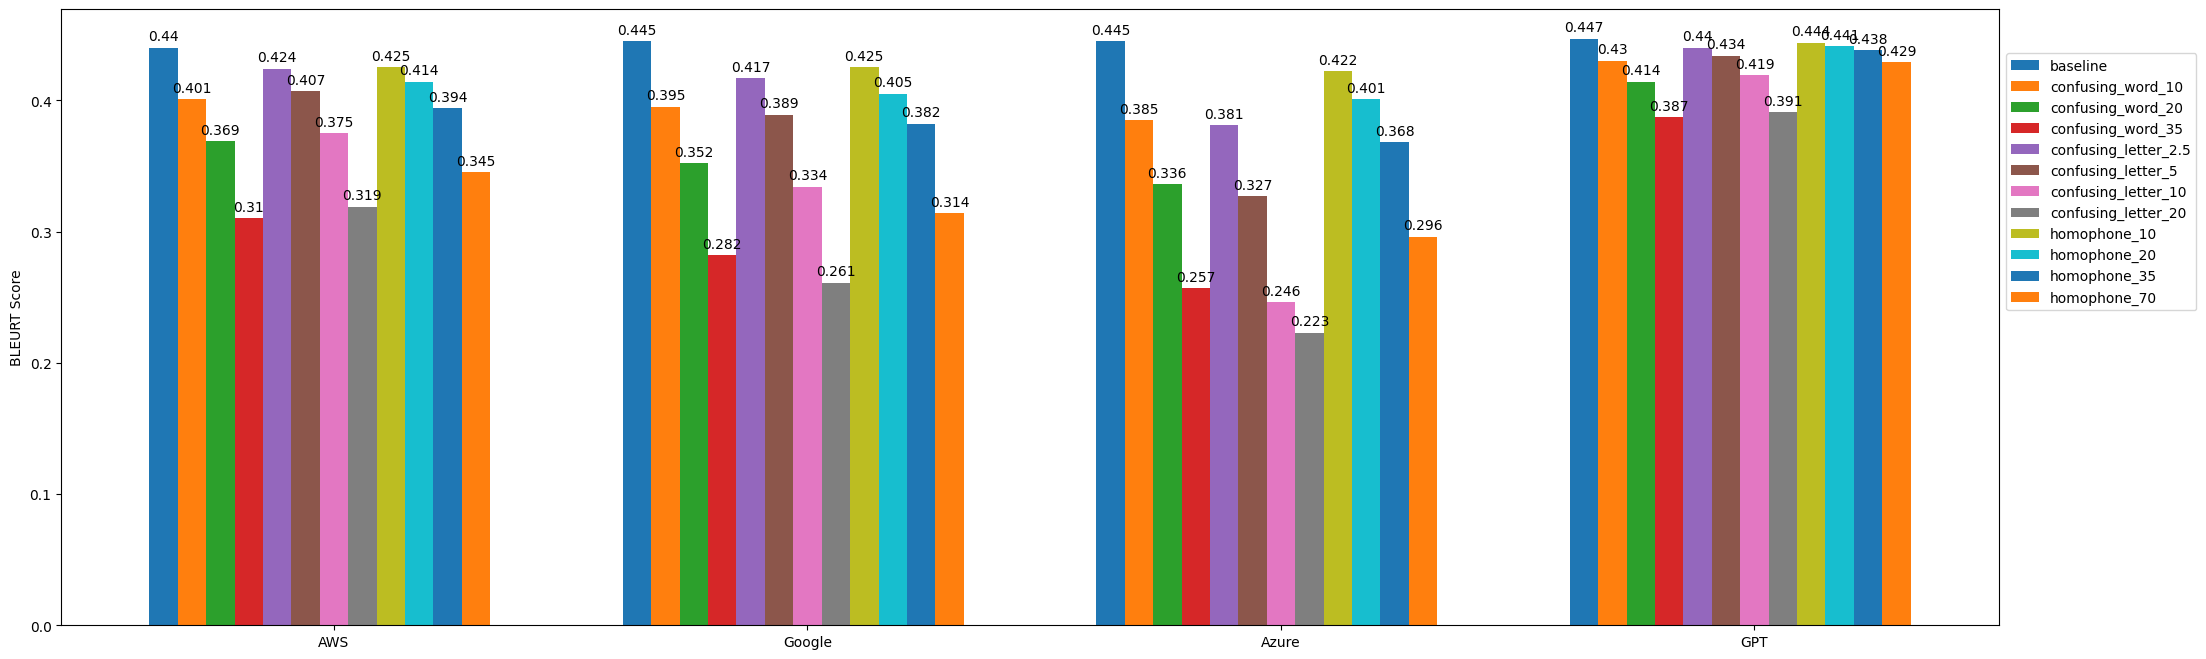

In [17]:
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline_bleuRT,
    'confusing_word_10': confusing_word_10_bleuRT[0:-1],
    'confusing_word_20': confusing_word_20_bleuRT[0:-1],
    'confusing_word_35': confusing_word_35_bleuRT[0:-1],
    'confusing_letter_2.5': confusing_letter_2_5_bleuRT[0:-1],
    'confusing_letter_5': confusing_letter_5_bleuRT[0:-1],
    'confusing_letter_10': confusing_letter_10_bleuRT[0:-1],
    'confusing_letter_20': confusing_letter_20_bleuRT[0:-1],
    'homophone_10': homophone_10_bleuRT[0:-1],
    'homophone_20': homophone_20_bleuRT[0:-1],
    'homophone_35': homophone_35_bleuRT[0:-1],
    'homophone_70': homophone_70_bleuRT[0:-1]
}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('BLEURT Score')
#ax.set_title('BLEU Score by Service and Injection Type')
#center the x ticks
ax.set_xticks(x+width*6, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()


In [18]:
#print SE for BLEURT scores
print(f"Baseline: AWS: {baseline_bleuRT_se[0]}, Google: {baseline_bleuRT_se[1]}, Azure: {baseline_bleuRT_se[2]}, GPT: {baseline_bleuRT_se[3]}")
print(f"Confusing Word 10: AWS:{confusing_word_10_bleuRT_se[0]}, Google:{confusing_word_10_bleuRT_se[1]}, Azure:{confusing_word_10_bleuRT_se[2]}, GPT:{confusing_word_10_bleuRT_se[3]}")
print(f"Confusing Word 20: AWS:{confusing_word_20_bleuRT_se[0]}, Google:{confusing_word_20_bleuRT_se[1]}, Azure:{confusing_word_20_bleuRT_se[2]}, GPT:{confusing_word_20_bleuRT_se[3]}")
print(f"Confusing Word 35: AWS:{confusing_word_35_bleuRT_se[0]}, Google:{confusing_word_35_bleuRT_se[1]}, Azure:{confusing_word_35_bleuRT_se[2]}, GPT:{confusing_word_35_bleuRT_se[3]}")
print(f"Confusing Letter 2.5: AWS:{confusing_letter_2_5_bleuRT_se[0]}, Google:{confusing_letter_2_5_bleuRT_se[1]}, Azure:{confusing_letter_2_5_bleuRT_se[2]}, GPT:{confusing_letter_2_5_bleuRT_se[3]}")
print(f"Confusing Letter 5: AWS:{confusing_letter_5_bleuRT_se[0]}, Google:{confusing_letter_5_bleuRT_se[1]}, Azure:{confusing_letter_5_bleuRT_se[2]}, GPT:{confusing_letter_5_bleuRT_se[3]}")
print(f"Confusing Letter 10: AWS:{confusing_letter_10_bleuRT_se[0]}, Google:{confusing_letter_10_bleuRT_se[1]}, Azure:{confusing_letter_10_bleuRT_se[2]}, GPT:{confusing_letter_10_bleuRT_se[3]}")
print(f"Confusing Letter 20: AWS:{confusing_letter_20_bleuRT_se[0]}, Google:{confusing_letter_20_bleuRT_se[1]}, Azure:{confusing_letter_20_bleuRT_se[2]}, GPT:{confusing_letter_20_bleuRT_se[3]}")
print(f"Homophone 10: AWS:{homophone_10_bleuRT_se[0]}, Google:{homophone_10_bleuRT_se[1]}, Azure:{homophone_10_bleuRT_se[2]}, GPT:{homophone_10_bleuRT_se[3]}")
print(f"Homophone 20: AWS:{homophone_20_bleuRT_se[0]}, Google:{homophone_20_bleuRT_se[1]}, Azure:{homophone_20_bleuRT_se[2]}, GPT:{homophone_20_bleuRT_se[3]}")
print(f"Homophone 35: AWS:{homophone_35_bleuRT_se[0]}, Google:{homophone_35_bleuRT_se[1]}, Azure:{homophone_35_bleuRT_se[2]}, GPT:{homophone_35_bleuRT_se[3]}")
print(f"Homophone 70: AWS:{homophone_70_bleuRT_se[0]}, Google:{homophone_70_bleuRT_se[1]}, Azure:{homophone_70_bleuRT_se[2]}, GPT:{homophone_70_bleuRT_se[3]}")


Baseline: AWS: 0.0016170498070300818, Google: 0.0016429117599019807, Azure: 0.0016483341647044755, GPT: 0.0016233252197527226
Confusing Word 10: AWS:0.002094939501598651, Google:0.0022020730238279935, Azure:0.002284891202255723, GPT:0.0018278339884178064
Confusing Word 20: AWS:0.0023438902005832466, Google:0.002478200024402029, Azure:0.002528854742418187, GPT:0.0020074169762104325
Confusing Word 35: AWS:0.0026592953017677856, Google:0.0027304096016812617, Azure:0.002713033971806482, GPT:0.00229441134782588
Confusing Letter 2.5: AWS:0.0017520688941203373, Google:0.0018939069725681975, Azure:0.002108616331046329, GPT:0.0016992221436335005
Confusing Letter 5: AWS:0.0019222421392327532, Google:0.0020761663183178065, Azure:0.002275496378320801, GPT:0.0017535179121249413
Confusing Letter 10: AWS:0.002157552263958923, Google:0.002292376994795752, Azure:0.0022562906015523108, GPT:0.001888575288329539
Confusing Letter 20: AWS:0.002452397623753823, Google:0.002391146702391918, Azure:0.0022819572

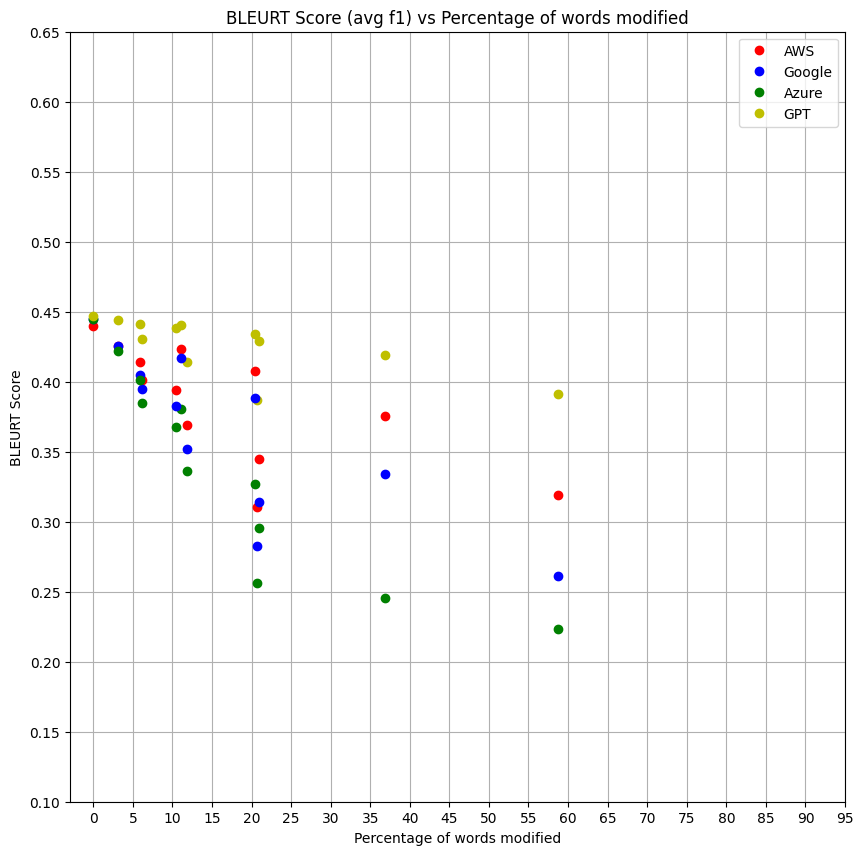

In [20]:
#same as above but for BLEURT_score
all_data = {
    0: baseline_bleuRT,
    confusing_word_10_bleuRT[-1]: confusing_word_10_bleuRT[0:-1],
    confusing_word_20_bleuRT[-1]: confusing_word_20_bleuRT[0:-1],
    confusing_word_35_bleuRT[-1]: confusing_word_35_bleuRT[0:-1],
    confusing_letter_2_5_bleuRT[-1]: confusing_letter_2_5_bleuRT[0:-1],
    confusing_letter_5_bleuRT[-1]: confusing_letter_5_bleuRT[0:-1],
    confusing_letter_10_bleuRT[-1]: confusing_letter_10_bleuRT[0:-1],
    confusing_letter_20_bleuRT[-1]: confusing_letter_20_bleuRT[0:-1],
    confusing_word_35_bleuRT[-1]: confusing_word_35_bleuRT[0:-1],
    homophone_10_bleuRT[-1]: homophone_10_bleuRT[0:-1],
    homophone_20_bleuRT[-1]: homophone_20_bleuRT[0:-1],
    homophone_35_bleuRT[-1]: homophone_35_bleuRT[0:-1],
    homophone_70_bleuRT[-1]: homophone_70_bleuRT[0:-1],
}

fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('BLEURT Score (avg f1) vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('BLEURT Score')
ax.legend(services)

#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.10, 0.70, 0.05))
ax.set_xticks(np.arange(0, 100, 5))
#show grid
ax.grid(True)
plt.show()



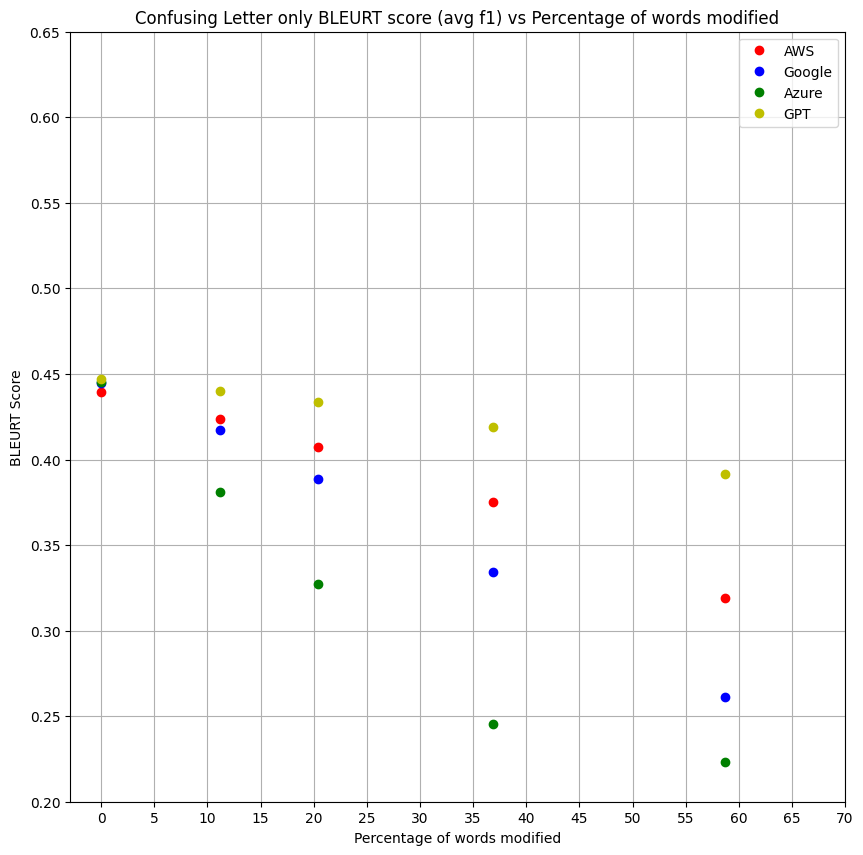

In [21]:
all_data = {
    0: baseline_bleuRT,
    confusing_letter_2_5_bleuRT[-1]: confusing_letter_2_5_bleuRT[0:-1],
    confusing_letter_5_bleuRT[-1]: confusing_letter_5_bleuRT[0:-1],
    confusing_letter_10_bleuRT[-1]: confusing_letter_10_bleuRT[0:-1],
    confusing_letter_20_bleuRT[-1]: confusing_letter_20_bleuRT[0:-1],
}


fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Confusing Letter only BLEURT score (avg f1) vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('BLEURT Score')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.2, 0.70, 0.05))
ax.set_xticks(np.arange(0, 75, 5))
#show grid
ax.grid(True)
plt.show()

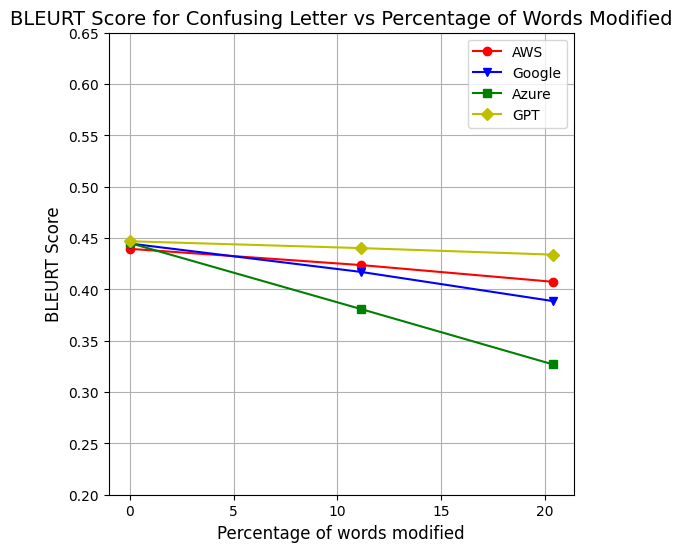

In [22]:
#same as above but for BLEURT score
all_data_2_confusing_letter = {
    'AWS': [baseline_bleuRT[0], confusing_letter_2_5_bleuRT[0], confusing_letter_5_bleuRT[0]],
    'Google': [baseline_bleuRT[1], confusing_letter_2_5_bleuRT[1], confusing_letter_5_bleuRT[1]],
    'Azure': [baseline_bleuRT[2], confusing_letter_2_5_bleuRT[2], confusing_letter_5_bleuRT[2]],
    'GPT': [baseline_bleuRT[3], confusing_letter_2_5_bleuRT[3], confusing_letter_5_bleuRT[3]]

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_letter_2_5_bleuRT[-1], confusing_letter_5_bleuRT[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_letter.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('BLEURT Score for Confusing Letter vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('BLEURT Score', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.20, 0.7, 0.05))
ax.set_xticks(np.arange(0, 21, 5))
#show grid
ax.grid(True)

plt.show()

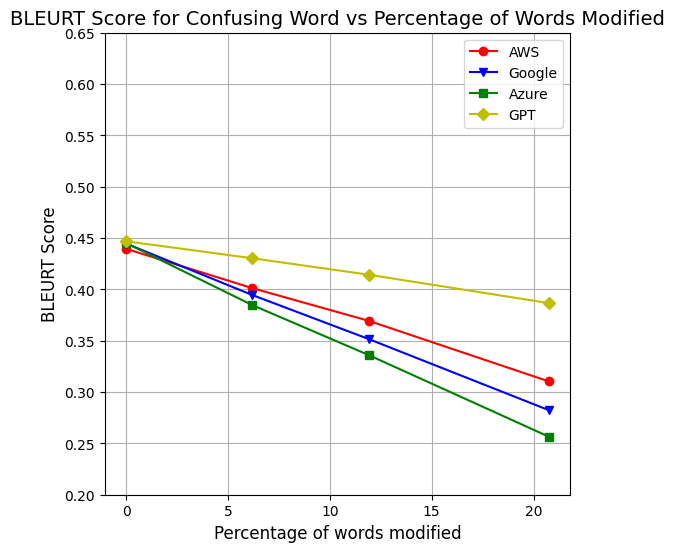

In [23]:
#same as previous but for Confusing word
all_data_2_confusing_word = {
    'AWS': [baseline_bleuRT[0], confusing_word_10_bleuRT[0], confusing_word_20_bleuRT[0], confusing_word_35_bleuRT[0]],
    'Google': [baseline_bleuRT[1], confusing_word_10_bleuRT[1], confusing_word_20_bleuRT[1], confusing_word_35_bleuRT[1]],
    'Azure': [baseline_bleuRT[2], confusing_word_10_bleuRT[2], confusing_word_20_bleuRT[2], confusing_word_35_bleuRT[2]],
    'GPT': [baseline_bleuRT[3], confusing_word_10_bleuRT[3], confusing_word_20_bleuRT[3], confusing_word_35_bleuRT[3]],

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_word_10_bleuRT[-1], confusing_word_20_bleuRT[-1], confusing_word_35_bleuRT[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_word.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('BLEURT Score for Confusing Word vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('BLEURT Score', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.20, 0.7, 0.05))
ax.set_xticks(np.arange(0, 21, 5))
#show grid
ax.grid(True)

plt.show()

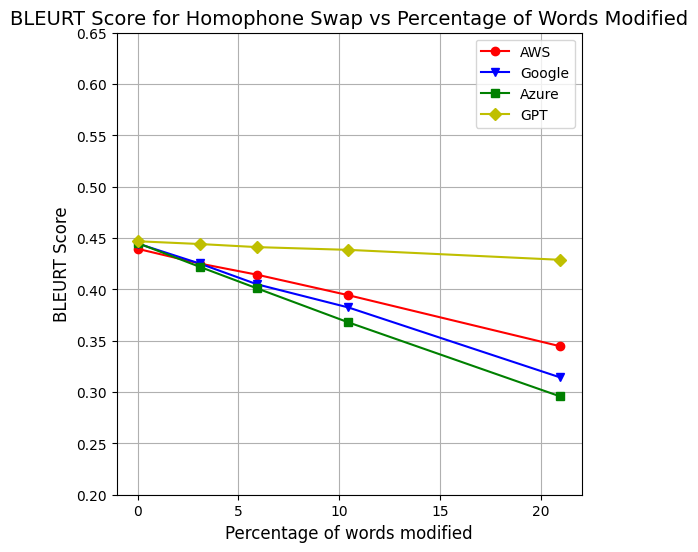

In [24]:
#same for homophone swapping

all_data_2_homophone = {
    'AWS': [baseline_bleuRT[0], homophone_10_bleuRT[0], homophone_20_bleuRT[0], homophone_35_bleuRT[0], homophone_70_bleuRT[0]],
    'Google': [baseline_bleuRT[1], homophone_10_bleuRT[1], homophone_20_bleuRT[1], homophone_35_bleuRT[1], homophone_70_bleuRT[1]],
    'Azure': [baseline_bleuRT[2], homophone_10_bleuRT[2], homophone_20_bleuRT[2], homophone_35_bleuRT[2], homophone_70_bleuRT[2]],
    'GPT': [baseline_bleuRT[3], homophone_10_bleuRT[3], homophone_20_bleuRT[3], homophone_35_bleuRT[3], homophone_70_bleuRT[3]],

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, homophone_10_bleuRT[-1], homophone_20_bleuRT[-1], homophone_35_bleuRT[-1], homophone_70_bleuRT[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0

for x, data in all_data_2_homophone.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('BLEURT Score for Homophone Swap vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('BLEURT Score', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)

#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.20, 0.7, 0.05))
ax.set_xticks(np.arange(0, 22, 5))
#show grid
ax.grid(True)
plt.show()

